In [6]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import optimizers
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [7]:
ref = pd.read_csv("/kaggle/input/data-path/Data_path.csv")
ref.head()

,labels,source,path
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [8]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[-15.78668, -18.798388, -25.468557, -25.198942..."
1,"[-25.571018, -29.788473, -39.008785, -41.50939..."
2,"[-8.769985, -12.6431875, -22.50932, -22.320293..."
3,"[-8.750768, -13.025253, -24.368538, -23.824284..."
4,"[-17.825218, -19.968874, -22.26418, -22.016508..."


In [9]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-15.786680,-18.798388,-25.468557,-25.198942,-25.429790,-23.347935,-16.800251,...,-3.119453,-4.260777,-5.274272,-5.775264,-7.272361,-7.340225,-7.019254,-8.643790,-15.047346,-14.076212
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.571018,-29.788473,-39.008785,-41.509392,-39.770164,-34.743958,-30.551401,...,-27.156343,-25.647068,-25.140005,-26.746452,-27.039562,-27.250130,-26.599064,-25.778673,-24.299049,-23.552532
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.769985,-12.643188,-22.509319,-22.320293,-17.513346,-12.073632,-9.537951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.750768,-13.025253,-24.368538,-23.824284,-20.085262,-20.491524,-21.797201,...,-11.261944,-12.151449,-13.157601,-13.586170,-14.427000,-15.093403,-13.683895,-13.934831,-6.858001,-1.180128
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-17.825218,-19.968874,-22.264179,-22.016508,-23.868864,-23.068272,-23.807617,...,-27.922167,-27.525471,-27.459105,-26.916115,-27.472073,-29.056601,-28.666269,-28.376913,-22.565571,-17.198839


In [10]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-15.786680,-18.798388,-25.468557,-25.198942,-25.429790,-23.347935,-16.800251,...,-3.119453,-4.260777,-5.274272,-5.775264,-7.272361,-7.340225,-7.019254,-8.643790,-15.047346,-14.076212
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.571018,-29.788473,-39.008785,-41.509392,-39.770164,-34.743958,-30.551401,...,-27.156343,-25.647068,-25.140005,-26.746452,-27.039562,-27.250130,-26.599064,-25.778673,-24.299049,-23.552532
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.769985,-12.643188,-22.509319,-22.320293,-17.513346,-12.073632,-9.537951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.750768,-13.025253,-24.368538,-23.824284,-20.085262,-20.491524,-21.797201,...,-11.261944,-12.151449,-13.157601,-13.586170,-14.427000,-15.093403,-13.683895,-13.934831,-6.858001,-1.180128
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-17.825218,-19.968874,-22.264179,-22.016508,-23.868864,-23.068272,-23.807617,...,-27.922167,-27.525471,-27.459105,-26.916115,-27.472073,-29.056601,-28.666269,-28.376913,-22.565571,-17.198839


In [11]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

#Before normalization
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-17.142694,-17.249537,-18.365582,-18.948351,-17.365459,-16.711090,-17.699482,-18.021381,-17.897398,-15.878503,...,-22.865425,-21.614164,-19.724932,-18.845333,-19.363424,-20.137630,-22.655138,-24.578312,-24.039165,-23.209587
3860,-12.833129,-16.663576,-22.940784,-22.980495,-23.782856,-25.614420,-27.344994,-25.838722,-23.915997,-26.146423,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-4.823565,-6.056047,-9.580621,-12.012060,-9.959867,-11.912550,-13.994515,-13.555813,-14.022306,-15.118245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-7.031147,-4.253552,-4.534488,-5.836689,-5.248198,-6.456452,-8.122450,-9.154640,-8.647813,-8.178625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-22.565975,-21.767017,-20.529488,-20.669310,-21.171089,-18.573404,-18.412350,-16.178038,-14.222460,-15.122540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-20.082027,-18.982424,-17.009443,-16.944057,-19.334974,-19.527683,-21.974348,-20.144060,-17.954929,-19.302570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-20.103537,-18.625866,-16.116108,-16.929590,-18.197664,-18.149662,-19.240429,-18.361645,-16.917976,-16.639193,...,-17.848896,-19.357054,-17.748701,-19.136810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-21.078182,-18.671947,-17.676804,-18.009504,-18.218782,-18.676929,-16.592766,-17.796528,-17.992470,-17.824917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-22.707441,-20.160748,-18.926155,-19.429981,-19.278114,-18.125767,-18.068565,-19.879320,-20.896751,-19.176098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-20.008291,-17.640305,-19.188614,-18.435749,-17.538836,-17.817177,-17.898472,-20.555359,-18.578112,-15.957151,...,-18.031603,-18.101122,-19.630693,-20.707489,-20.239124,-18.337662,-15.543310,-17.478794,-17.017057,-19.112492


In [12]:
# data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.374370,0.352676,0.438718,0.388605,0.498415,0.541699,0.460560,0.431723,0.435423,0.581450,...,-0.877277,-0.810076,-0.689280,-0.627077,-0.673167,-0.716267,-0.859700,-0.982784,-0.968884,-0.914848
3860,0.684896,0.395888,0.099446,0.090097,0.024151,-0.116464,-0.250588,-0.144181,-0.007876,-0.174500,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
9761,1.262025,1.178140,1.090163,0.902112,1.045709,0.896423,0.733722,0.760701,0.720842,0.637422,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
7620,1.102958,1.311065,1.464356,1.359287,1.393915,1.299756,1.166660,1.084935,1.116700,1.148334,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
11586,-0.016405,0.019535,0.278255,0.261199,0.217168,0.404031,0.408002,0.567522,0.706100,0.637106,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
7914,0.162576,0.224885,0.539282,0.536987,0.352862,0.333487,0.145381,0.275345,0.431186,0.329361,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
9513,0.161027,0.251179,0.605527,0.538058,0.436913,0.435355,0.346949,0.406655,0.507562,0.525446,...,-0.566322,-0.670504,-0.567512,-0.644924,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
5835,0.090798,0.247781,0.489794,0.458110,0.435352,0.396378,0.542157,0.448288,0.428421,0.438150,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
5389,-0.026598,0.137989,0.397149,0.352949,0.357064,0.437121,0.433349,0.294848,0.214506,0.338673,...,0.540061,0.526471,0.526092,0.526815,0.512163,0.512140,0.512775,0.500812,0.494086,0.487473
11222,0.167889,0.323859,0.377687,0.426554,0.485602,0.459933,0.445889,0.245045,0.385285,0.575659,...,-0.577647,-0.592841,-0.683473,-0.741096,-0.726773,-0.606468,-0.428857,-0.554243,-0.541534,-0.667302


In [13]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])


filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [14]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [15]:
# Baseline model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))

#let's check summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [16]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)#lr=0.00001, decay=1e-6
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


In [17]:
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 14s 11ms/step - loss: 2.4048 - accuracy: 0.1976 - val_loss: 2.4552 - val_accuracy: 0.2095
Epoch 2/100
571/571 [==============================] - 6s 10ms/step - loss: 2.1800 - accuracy: 0.2544 - val_loss: 2.2233 - val_accuracy: 0.2664
Epoch 3/100
571/571 [==============================] - 6s 10ms/step - loss: 2.0666 - accuracy: 0.2866 - val_loss: 2.1424 - val_accuracy: 0.3045
Epoch 4/100
571/571 [==============================] - 6s 10ms/step - loss: 1.9963 - accuracy: 0.3113 - val_loss: 2.0775 - val_accuracy: 0.3140
Epoch 5/100
571/571 [==============================] - 6s 10ms/step - loss: 1.9444 - accuracy: 0.3315 - val_loss: 2.0322 - val_accuracy: 0.3390
Epoch 6/100
571/571 [==============================] - 6s 10ms/step - loss: 1.8932 - accuracy: 0.3472 - val_loss: 1.9903 - val_accuracy: 0.3522
Epoch 7/100
571/571 [==============================] - 6s 10ms/step - loss: 1.8537 - accuracy: 0.3631 - val_loss: 1.9557 - val_accuracy

Finally our model got trained. It seems to be not that good. But yeah it works. It's just a baseline model and we can improve its accuracy as we work on it.

Let's plot the `training loss` and `Validation loss` of the model

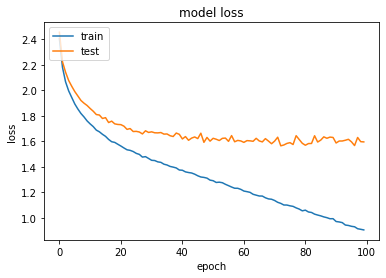

In [18]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.evaluate(X_test, y_test)

96/96 [==============================] - 1s 5ms/step - loss: 1.5960 - accuracy: 0.4476


[1.5959655046463013, 0.4475501477718353]

Accuracy is `44.59%`

In [20]:
# save model and weights
model_name = 'emotion_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models') # creates a folder in current working directory (CWD)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)   # adds file in folder
model.save(model_path)
print('Save model and weights at %s' % model_path)

model_json = model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/emotion_model.h5


In [21]:
# loading json and model architecture
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('saved_models/emotion_model.h5')
print('Model is loaded from disk')

# keras optimiser
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose = 0)
print('%s: %.2f%%' % (loaded_model.metrics_names[1], score[1]*100))

Model is loaded from disk
accuracy: 44.76%


In [22]:
predicted = loaded_model.predict(X_test, batch_size = 16, verbose = 1)
predicted = predicted.argmax(axis = 1)
predicted

191/191 [==============================] - 1s 2ms/step


array([11,  3, 10, ..., 12,  1,  0])

In [23]:
len(predicted)

3041

In [24]:
# predictions
predicted = predicted.astype(int).flatten()
predicted = (lb.inverse_transform(predicted))
predicted = pd.DataFrame({'predictedvalues': predicted})

# Actual Labels
actual = y_test.argmax(axis=1)  # returns indices of maimum value
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform(actual))
actual = pd.DataFrame({'actualvalues': actual})

# Let's combine both of them into a single dataframe
final_df = actual.join(predicted)
final_df[170:180]

,actualvalues,predictedvalues
170,male_sad,female_disgust
171,female_disgust,female_happy
172,male_angry,male_happy
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_fear
176,male_fear,male_neutral
177,female_fear,male_sad
178,female_happy,female_disgust
179,female_neutral,female_neutral


In [25]:
final_df.to_csv('Predictions.csv', index = False)
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,317
female_disgust,400
female_fear,289
female_happy,385
female_neutral,236
female_sad,292
female_surprise,119
male_angry,179
male_disgust,89


In [26]:
def print_confusion_matrix(confusion_matrix, class_name, figsize=(10,7), fontsize = 14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index = class_name, columns = class_name)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

#### Emotion by gender accuracy


0.4475501479776389


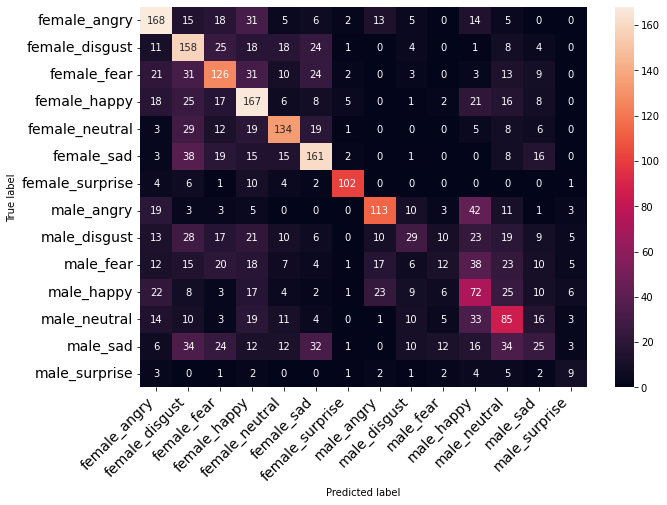

In [27]:
# get prediction file
final_df = pd.read_csv('Predictions.csv')
classes = final_df.actualvalues.unique()
classes.sort()

#confusion matrix
c = confusion_matrix(final_df.actualvalues, final_df.predictedvalues)
print(accuracy_score(final_df.actualvalues, final_df.predictedvalues))
print_confusion_matrix(c, classes)

In [28]:
classes = final_df.actualvalues.unique()
classes.sort()
print(classification_report(final_df.actualvalues, final_df.predictedvalues, target_names = classes))

                 precision    recall  f1-score   support

   female_angry       0.53      0.60      0.56       282
 female_disgust       0.40      0.58      0.47       272
    female_fear       0.44      0.46      0.45       273
   female_happy       0.43      0.57      0.49       294
 female_neutral       0.57      0.57      0.57       236
     female_sad       0.55      0.58      0.56       278
female_surprise       0.86      0.78      0.82       130
     male_angry       0.63      0.53      0.58       213
   male_disgust       0.33      0.14      0.20       200
      male_fear       0.23      0.06      0.10       188
     male_happy       0.26      0.35      0.30       208
   male_neutral       0.33      0.40      0.36       214
       male_sad       0.22      0.11      0.15       221
  male_surprise       0.26      0.28      0.27        32

       accuracy                           0.45      3041
      macro avg       0.43      0.43      0.42      3041
   weighted avg       0.44   

#### Gender Accuracy result


0.7951331798750411


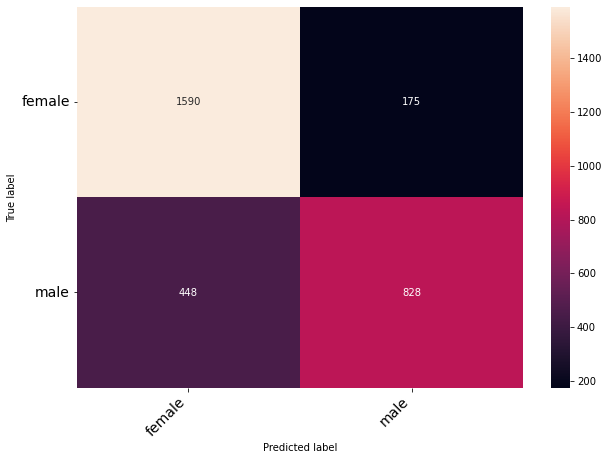

In [29]:
modidf = final_df
modidf['actualvalues'] = final_df.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = final_df.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_name = classes)

In [30]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.78      0.90      0.84      1765
        male       0.83      0.65      0.73      1276

    accuracy                           0.80      3041
   macro avg       0.80      0.77      0.78      3041
weighted avg       0.80      0.80      0.79      3041



With just gender 80% accuracy.

#### Emotion accuracy
ignoring the gender part and grouping into the 7 core emotions

0.5103584347254193


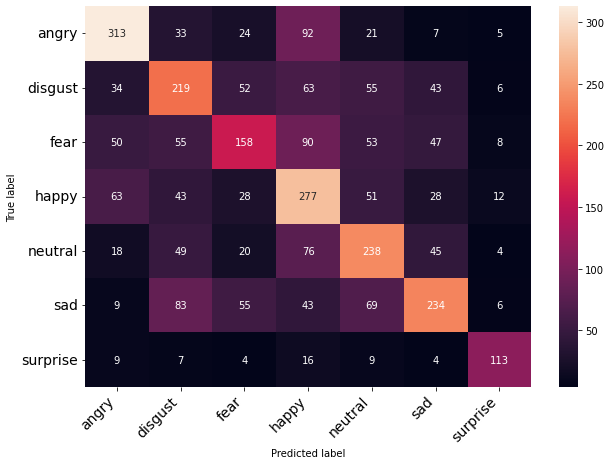

In [31]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_name = classes)

In [32]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.63      0.63      0.63       495
     disgust       0.45      0.46      0.46       472
        fear       0.46      0.34      0.39       461
       happy       0.42      0.55      0.48       502
     neutral       0.48      0.53      0.50       450
         sad       0.57      0.47      0.52       499
    surprise       0.73      0.70      0.72       162

    accuracy                           0.51      3041
   macro avg       0.54      0.53      0.53      3041
weighted avg       0.52      0.51      0.51      3041

